In [3]:
import torch
import torch.nn as nn
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from model import *
from utils import *
from dataloader import *
%matplotlib inline

In [2]:
# model = Resv2Unet(nlayers = 6, nefilters = 15)
# model = nn.DataParallel(model)
model = Unet(nlayers = 6,nefilters=12)
model.cuda()

Unet(
  (encoder): ModuleList(
    (0): Conv1d(1, 12, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Conv1d(12, 24, kernel_size=(15,), stride=(1,), padding=(7,))
    (2): Conv1d(24, 36, kernel_size=(15,), stride=(1,), padding=(7,))
    (3): Conv1d(36, 48, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): Conv1d(48, 60, kernel_size=(15,), stride=(1,), padding=(7,))
    (5): Conv1d(60, 72, kernel_size=(15,), stride=(1,), padding=(7,))
  )
  (decoder): ModuleList(
    (0): Conv1d(144, 72, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(132, 60, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(108, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Conv1d(84, 36, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): Conv1d(60, 24, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): Conv1d(36, 12, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (ebatch): ModuleList(
    (0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running

In [3]:
# model.load_state_dict(torch.load('./models/Resv2Unet/best_val.pth'))
model.load_state_dict(torch.load('./models/Unet/best_val_past.pth'))

In [53]:
n_frame = 576
n_shift = n_frame//3

def inference(model,x,n_frame = 576, n_shift_ratio = 3):
    model.eval()
    n_shift = n_frame//n_shift_ratio
    x_ = []
    result = np.zeros(shape = x.shape)
    step = 0
    x = butter_lowpass_filter(x,2500,16000)
    while(step*n_shift + n_frame <= len(x)):
        x_.append(normalize(x[step*n_shift:step*n_shift+n_frame]))
        step +=1
    x_ = np.array(x_)
    x_ = np.expand_dims(x_,axis=-1)
    x_ = torch.Tensor(x_).float().cuda()
    
    pred = model(x_)
    pred = pred.cpu().detach().numpy()
    pred = pred[:,:,0]
    for step in range(len(pred)):
        result[step*n_shift : step*n_shift + n_frame]+=pred[step]
    for step in range(len(pred)):
        k = min(step+1, n_shift_ratio, len(pred)-step)
        result[step*n_shift : (step+1)*n_shift]/= k
    
    return result

In [5]:
x, sr = librosa.load('./datasets/saarbrucken/export/1-iau.wav',sr = 50000)
x = librosa.resample(x,sr,16000)

y,sr = librosa.load('./datasets/saarbrucken/export/1-iau-egg.wav',sr = 50000)
y = librosa.resample(y,sr,16000)

In [44]:
x, sr = librosa.load('./datasets/cmu_us_bdl_arctic/orig/arctic_b0001.wav',sr=16000,mono=False)

x,y = x[0],x[1]

In [54]:
print(x.shape)
result = inference(model,x,n_frame = 576, n_shift_ratio = 3)

(27200,)
torch.Size([139, 576, 1])


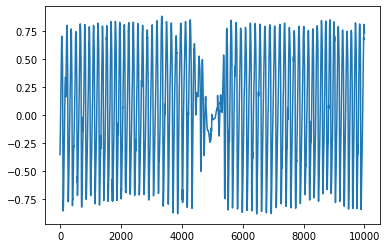

In [57]:
plt.plot(result[5000:15000])

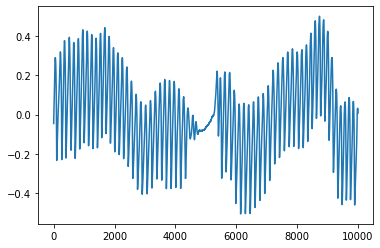

In [56]:
plt.plot(y[5000:15000])

In [63]:
from scipy.signal import savgol_filter

In [58]:
def DEGG(EGG):
    DEGG = np.zeros(EGG.shape)
    for i in range(len(EGG)-1):
        DEGG[i] = EGG[i+1]-EGG[i]
    return DEGG

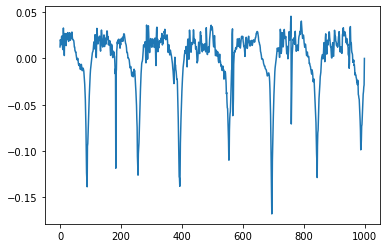

In [62]:
plt.plot(DEGG(result[5000:6000]))

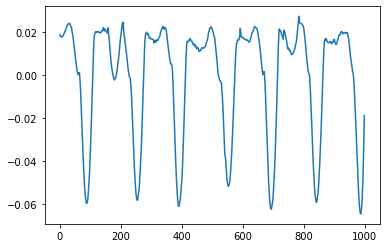

In [74]:
plt.plot(savgol_filter(DEGG(result[5000:6000]), 51, 3))

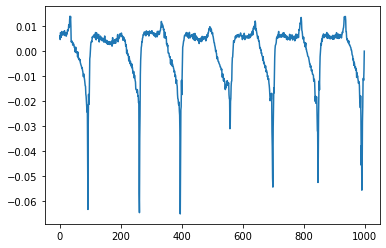

In [61]:
plt.plot(DEGG(y[5000:6000]))

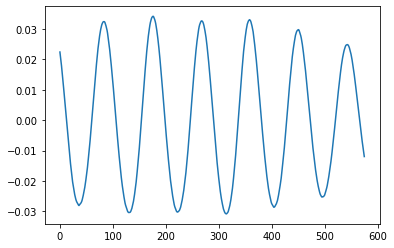

In [37]:
plt.plot(x[4000:4000+n_frame])

In [38]:
%%time

import torch.utils.data as data

x_ = x[4000:4000+n_frame]
x_ = butter_lowpass_filter(x_,2500,16000)
x_ = normalize(x_)
x_ = np.expand_dims(np.expand_dims(x_,axis=-1),axis=0)
x_ = torch.Tensor(x_).float().cuda()

model.eval()
pred = model(x_.float().cuda())

# result = inference(model,x[400000:400000+n_frame])
# plt.plot(result)

torch.Size([1, 576, 1])
CPU times: user 8.32 ms, sys: 104 ms, total: 112 ms
Wall time: 112 ms


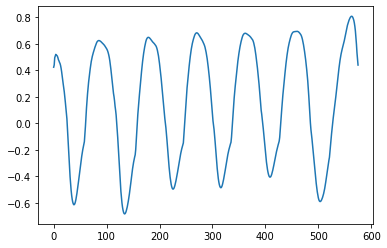

In [39]:
plt.plot(pred.cpu().detach().numpy()[0])

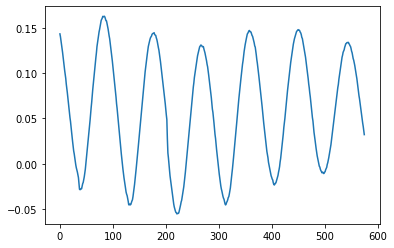

In [40]:
plt.plot(y[4000:4000+n_frame])